In [32]:
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,GRU
import matplotlib.pyplot as plt
import joblib

In [7]:
# Define la ruta de la carpeta procesada
PROCESSED_DATA_PATH = "data_processed" 

# Cargar los datos diarios de entrenamiento y testeo
df_train_val = pd.read_csv(
    os.path.join(PROCESSED_DATA_PATH, "df_diario_train_val.csv"), 
    index_col='timestamp', 
    parse_dates=True
)
df_test_final = pd.read_csv(
    os.path.join(PROCESSED_DATA_PATH, "df_diario_test_final.csv"), 
    index_col='timestamp', 
    parse_dates=True
)

print("Datos diarios cargados con éxito.")
print(f"Set de Entrenamiento/Validación: {len(df_train_val)} registros.")
print("--- División del Dataset ---")
print(f"Inicio del Set de Entrenamiento/Validación: {df_train_val.index.min()}")
print(f"Fin del Set de Entrenamiento/Validación: {df_train_val.index.max()} ({len(df_train_val)} días)")
print("-" * 30)
print(f"Inicio del Set de Testeo Final: {df_test_final.index.min()}")
print(f"Fin del Set de Testeo Final: {df_test_final.index.max()} ({len(df_test_final)} días)")

Datos diarios cargados con éxito.
Set de Entrenamiento/Validación: 1827 registros.
--- División del Dataset ---
Inicio del Set de Entrenamiento/Validación: 2020-01-01 00:00:00
Fin del Set de Entrenamiento/Validación: 2024-12-31 00:00:00 (1827 días)
------------------------------
Inicio del Set de Testeo Final: 2025-01-01 00:00:00
Fin del Set de Testeo Final: 2025-09-24 00:00:00 (267 días)


In [ ]:
#Escalado y Normalización (MinMaxScaler)
#Las redes neuronales recurrentes funcionan mucho mejor cuando las entradas están normalizadas, generalmente en el rango [0, 1]
from sklearn.preprocessing import MinMaxScaler

df_train_val['volatilidad'] = df_train_val['high'] - df_train_val['low']    # 1. Crear la característica de Volatilidad (High - Low)
#analizar_y_graficar_df(df_train_val, titulo_grafico='Precio de Bitcoin desde 2020 hasta 2025')



features = ['open', 'high', 'low', 'close', 'volume', 'volatilidad']    # 2. Seleccionar las columnas que vamos a usar como características (features)
data = df_train_val[features].values    # Es mejor usar Open, High, Low, Close, Volume, y la Volatilidad que creamos.  
                                        # Convertir a array de NumPy

scaler = MinMaxScaler(feature_range=(0, 1))     # 3. Inicializar y Ajustar el Escalador (SOLO en los datos de entrenamiento)
scaled_data = scaler.fit_transform(data)

print("\n--- Escalado de Datos ---")
print(f"Forma del Array escalado: {scaled_data.shape}")     #(1827,6) 1827 días y 6 features
print(f"Valores máximos después del escalado: {scaled_data.max(axis=0)}")



--- Escalado de Datos ---
Forma del Array escalado: (1827, 6)
Valores máximos después del escalado: [1. 1. 1. 1. 1. 1.]


In [9]:
#Creación de Secuencias Temporales (X e Y)
# En este paso convertiremos la serie temporal continua en muestras de entrenamiento 
#   con un tamaño de ventana (timestep).
# 
# Para el modelo de días,   usaremos una ventana grande de 60 días de datos pasados 
#                                      para predecir el precio de cierre del día 61.
# 
# X (Features/Entrada): Muestra de 60 días (60, 6 características)
# 
# Y (Label/Salida): El precio de cierre del día siguiente (1 valor)

import numpy as np

# Definir la ventana de tiempo (timestep)
TIMESTEP = 60

# Listas para almacenar las secuencias
X_train = []
Y_train = []

# Iterar sobre el array escalado para crear las secuencias
for i in range(TIMESTEP, len(scaled_data)):
    # X_train contendrá los 60 valores anteriores (días i-60 hasta i-1)
    X_train.append(scaled_data[i-TIMESTEP:i, :]) 
    
    # Y_train contendrá el precio de CIERRE del día actual (día i). 
    # El precio de cierre es la 4ta columna (índice 3) en nuestra lista 'features'.
    Y_train.append(scaled_data[i, features.index('close')])

# Convertir las listas a arreglos de NumPy
X_train, Y_train = np.array(X_train), np.array(Y_train)

# La forma de X_train debe ser: (Número de muestras, Timestep, Número de Características)
print("\n--- Creación de Secuencias para RNN ---")
print(f"Forma de X_train (muestras, pasos de tiempo, features): {X_train.shape}")
print(f"Forma de Y_train (muestras, valor a predecir): {Y_train.shape}")


--- Creación de Secuencias para RNN ---
Forma de X_train (muestras, pasos de tiempo, features): (1767, 60, 6)
Forma de Y_train (muestras, valor a predecir): (1767,)


In [10]:
#Modelo LSTM:
# Una capa recurrente con 50 unidades
# Una capa de Dropout para prevenir el sobreajuste.
# Una capa Densa (Dense) de salida con 1 unidad, 
#       utilizando activación lineal, ya que es una tarea de regresión 
#       (prediciendo un valor continuo: el precio).

def crear_modelo_lstm(input_shape):
    """Define y compila el modelo LSTM."""
    
    # El input_shape debe ser (TIMESTEP, features) -> (60, 6)
    model = Sequential()
    
    # Capa LSTM
    model.add(LSTM(
        units=50, 
        return_sequences=False, # False porque solo nos interesa la salida del último paso de tiempo
        input_shape=input_shape
    ))
    
    # Capa de Dropout (para regularización)
    model.add(Dropout(0.2))
    
    # Capa de Salida (Predicción de 1 valor: Precio de Cierre)
    model.add(Dense(units=1))
    
    # Compilación: Usamos 'adam' como optimizador y 'mean_squared_error' (MSE) como métrica
    # MSE es común en tareas de regresión.
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [ ]:
#Modelo GRU

def crear_modelo_gru(input_shape):
    """Define y compila el modelo GRU."""
    
    model = Sequential()
    
    # Capa GRU
    model.add(GRU(
        units=50, 
        return_sequences=False, 
        input_shape=input_shape
    ))
    
    # Capa de Dropout
    model.add(Dropout(0.2))
    
    # Capa de Salida
    model.add(Dense(units=1))
    
    # Compilación
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [ ]:
#Entrenamiento y Comparación Inicial

# Definir la forma de entrada: (Timesteps, Features)
# En este caso: (60, 6)
input_shape = (X_train.shape[1], X_train.shape[2]) 

# 1. Crear Modelos
modelo_lstm = crear_modelo_lstm(input_shape)
modelo_gru = crear_modelo_gru(input_shape)

print("--- Resumen del Modelo LSTM ---")
modelo_lstm.summary()

print("\n--- Resumen del Modelo GRU ---")
modelo_gru.summary()

print("\n--- Iniciando Entrenamiento LSTM ---")
history_lstm = modelo_lstm.fit(
    X_train, 
    Y_train, 
    epochs=25,        # Número de pasadas de entrenamiento
    batch_size=32,    # Tamaño de lote
    validation_split=0.2, 
    verbose=1
)

print("\n--- Iniciando Entrenamiento GRU ---")
history_gru = modelo_gru.fit(
    X_train, 
    Y_train, 
    epochs=25,        # Número de pasadas de entrenamiento
    batch_size=32,    # Tamaño de lote
    validation_split=0.2, 
    verbose=1
)

--- Resumen del Modelo LSTM ---


C:\Users\crges\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)


--- Resumen del Modelo GRU ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 50)             │         8,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,751 (34.18 KB)

 Trainable params: 8,751 (34.18 KB)

 Non-trainable params: 0 (0.00 B)


--- Iniciando Entrenamiento LSTM ---
Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0103 - val_loss: 0.0065
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.6097e-04 - val_loss: 0.0024
Epoch 9/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.2719e-04 - val_loss: 0.0010
Epoch 10/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.4077e-04 - val_loss: 0.0012
Epoch 11/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.4528e-04 - val_loss: 0.0015
Epoch 12/

In [18]:
def analizar_y_graficar_df(df: pd.DataFrame, titulo_grafico: str = 'Precio de Cierre (Serie Temporal)'):
    if 'close' in df.columns:
        plt.figure(figsize=(14, 6))
        # Graficamos el precio de cierre
        df['close'].plot(title=titulo_grafico, grid=True)
        plt.xlabel("Índice/Fecha") # Usamos 'Índice/Fecha' ya que no sabemos si el índice es datetime
        plt.ylabel("Precio (USD)")
        plt.show()
    else:
        print("\n Advertencia: La columna 'close' no se encontró en el DataFrame para graficar.")
        


--- Datos de Testeo Final ---


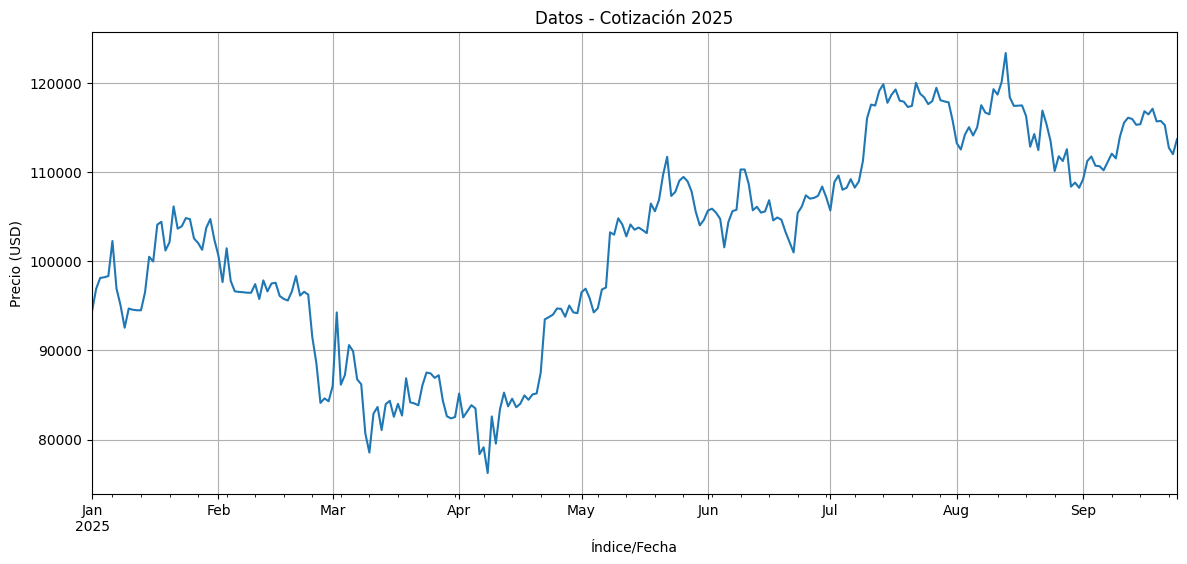

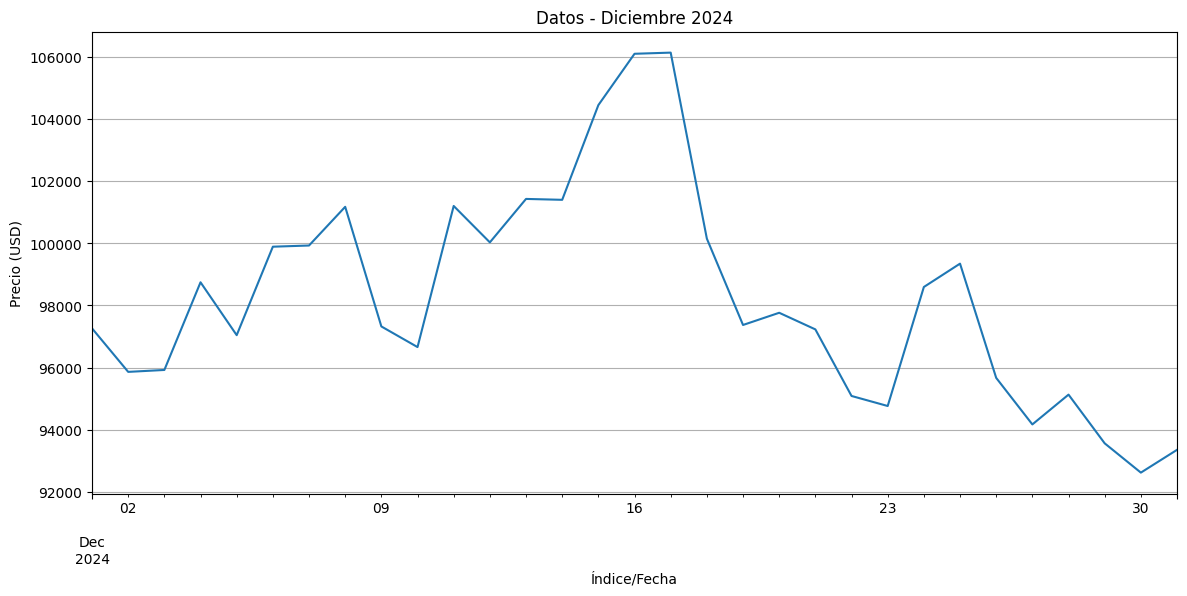

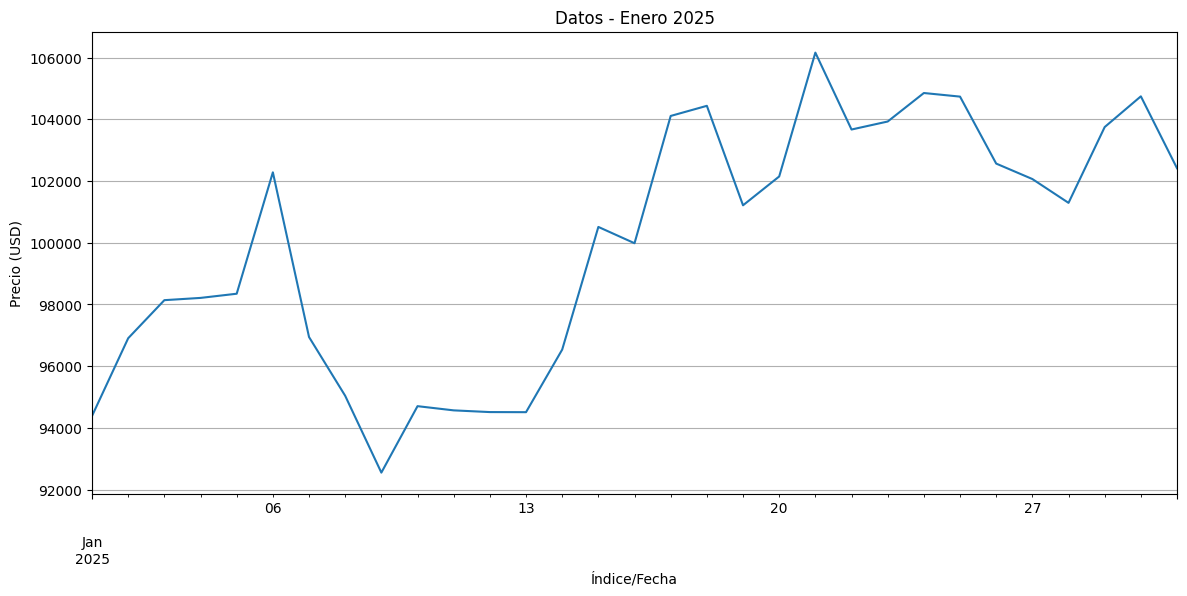

In [21]:
#df_test_final
print("\n--- Datos de Testeo Final ---");
analizar_y_graficar_df(df_test_final, titulo_grafico='Datos - Cotización 2025')

df_diciembre_24 = df_train_val.loc['2024-12-01':'2024-12-31']
analizar_y_graficar_df(df_diciembre_24, titulo_grafico='Datos - Diciembre 2024')


df_enero_25 = df_test_final.loc['2025-01-01':'2025-01-31']       # Desde 2025-01-01 en adelante  
analizar_y_graficar_df(df_enero_25, titulo_grafico='Datos - Enero 2025')


In [41]:
#Para predecir los valores de 2025:
# 1)Preparar los datos de 2025: Deben tener exactamente el mismo formato  
# (escalado, ventana de 60 días) que los datos de entrenamiento.
# Nota: La preparación de X_test es la misma para ambos modelos.

# Crear la característica de Volatilidad en el dataset final también
df_test_final['volatilidad'] = df_test_final['high'] - df_test_final['low']
dataset_completo = pd.concat((df_train_val[features].iloc[-TIMESTEP:], df_test_final[features]), axis=0)
data_test = dataset_completo[features].values
scaled_test_data = scaler.transform(data_test)
X_test = []
# Iteramos SÓLO sobre la longitud del dataset final
for i in range(TIMESTEP, len(scaled_test_data)):
    X_test.append(scaled_test_data[i-TIMESTEP:i, :])

X_test = np.array(X_test)

print(f"\nForma de X_test (muestras de 2025, 60, 6): {X_test.shape}")

# -----------------------------------------------------------
# PREDICCIÓN Y DESESCALADO: MODELO LSTM
# -----------------------------------------------------------

# 2)Predecir: Pasar estos datos al modelo (modelo_lstm.predict()).
# Generamos las predicciones escaladas (entre 0 y 1)
predictions_scaled_lstm = modelo_lstm.predict(X_test)

# 3)Desescalar: Convertir la predicción (que está entre 0 y 1) de vuelta a precios reales en dólares.
# 1. Crear un array fantasma para el desescalado
dummy_array_lstm = np.zeros(shape=(len(predictions_scaled_lstm), len(features)))

# 2. Colocar las predicciones escaladas en la columna de 'close' (índice 3)
close_idx = features.index('close')
dummy_array_lstm[:, close_idx] = predictions_scaled_lstm[:, 0]

# 3. Desescalar todo el array fantasma
predictions_descaled_lstm = scaler.inverse_transform(dummy_array_lstm)

# 4. Obtener las predicciones reales (solo la columna 'close')
precios_predichos_reales_lstm = predictions_descaled_lstm[:, close_idx]

print("\n--- Resultados de la Predicción LSTM ---")
print(f"Predicciones desescaladas (precios reales en USD): {precios_predichos_reales_lstm[:5]}")
print(f"Predicciones desescaladas de Enero 2025: {precios_predichos_reales_lstm[:31]}")

# -----------------------------------------------------------
# PREDICCIÓN Y DESESCALADO: MODELO GRU
# -----------------------------------------------------------

# Generamos las predicciones escaladas (entre 0 y 1) usando modelo_gru
predictions_scaled_gru = modelo_gru.predict(X_test)

# 1. Crear un array fantasma para el desescalado
dummy_array_gru = np.zeros(shape=(len(predictions_scaled_gru), len(features)))

# 2. Colocar las predicciones escaladas en la columna de 'close' (índice 3)
dummy_array_gru[:, close_idx] = predictions_scaled_gru[:, 0]

# 3. Desescalar todo el array fantasma
predictions_descaled_gru = scaler.inverse_transform(dummy_array_gru)

# 4. Obtener las predicciones reales (solo la columna 'close')
precios_predichos_reales_gru = predictions_descaled_gru[:, close_idx]

print("\n--- Resultados de la Predicción GRU ---")
print(f"Predicciones desescaladas (precios reales en USD): {precios_predichos_reales_gru[:5]}")
print(f"Predicciones desescaladas de Enero 2025: {precios_predichos_reales_gru[:31]}")


Forma de X_test (muestras de 2025, 60, 6): (267, 60, 6)
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

--- Resultados de la Predicción LSTM ---
Predicciones desescaladas (precios reales en USD): [94086.99941584 93848.01648295 94418.95436422 95356.65510512
 96491.03322183]
Predicciones desescaladas de Enero 2025: [ 94086.99941584  93848.01648295  94418.95436422  95356.65510512
  96491.03322183  97427.0074517   98429.65156918  98343.0362534
  96879.92681381  95494.5405545   94669.53993419  94639.72441672
  94821.99810257  94098.27606832  94112.34170017  95406.95935842
  96663.8473175   98474.02773215 100458.82119452 101417.11329604
 101173.46395396 101600.69092029 102793.54705233 103281.86594755
 104179.88711844 105153.47031243 105549.57782289 104134.40019312
 103511.47380479 103411.04036399 103857.10803289]
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

--- Resultados de la Predicción GRU ---
Predicciones desescaladas (precios reales en USD): [90632.85451244 91514.15991741 92921.27848344 94640.7385910

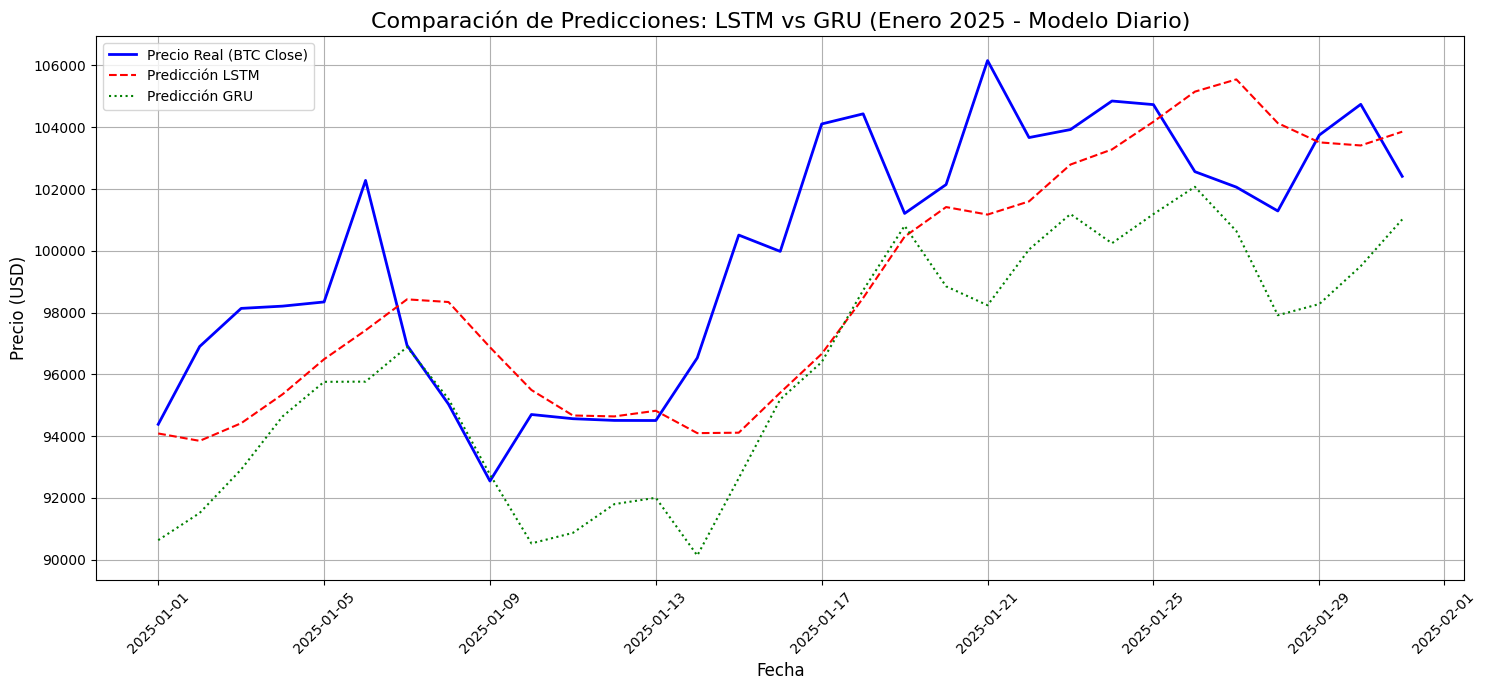

In [47]:
# 1. Obtener los arrays recortados para Enero 2025
dias_de_enero = 31 
precios_reales_enero = precios_reales[:dias_de_enero]

# Recortamos la predicción LSTM y GRU
precios_predichos_lstm_enero = precios_predichos_reales_lstm[:dias_de_enero]
precios_predichos_gru_enero = precios_predichos_reales_gru[:dias_de_enero] 

# 2. Obtener las fechas correspondientes para el eje X
fechas_enero = df_test_final.index[:dias_de_enero]


# 3. Generar el Gráfico Comparativo
plt.figure(figsize=(15, 7))

# Gráfico 1: Precio Real (la verdad)
plt.plot(fechas_enero, precios_reales_enero, label='Precio Real (BTC Close)', color='blue', linewidth=2)

# Gráfico 2: Predicción LSTM
plt.plot(fechas_enero, precios_predichos_lstm_enero,label='Predicción LSTM', color='red', linestyle='--', linewidth=1.5)

# AÑADIDO: Gráfico 3: Predicción GRU
plt.plot(fechas_enero, precios_predichos_gru_enero, 
         label='Predicción GRU', color='green', linestyle=':', linewidth=1.5)

plt.title('Comparación de Predicciones: LSTM vs GRU (Enero 2025 - Modelo Diario)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [48]:
# -----------------------------------------------------
# 1. Guardado del Modelo LSTM
# -----------------------------------------------------
# modelo_lstm es el modelo entrenado de LSTM
MODELO_NOMBRE_LSTM = 'modelo_lstm_diario.h5'
modelo_lstm.save(MODELO_NOMBRE_LSTM)
print(f"Modelo LSTM Diario guardado como: {MODELO_NOMBRE_LSTM}")

# -----------------------------------------------------
# 2. Guardado del Modelo GRU
# -----------------------------------------------------
# Asumimos que 'modelo_gru' también fue entrenado en este notebook.
MODELO_NOMBRE_GRU = 'modelo_gru_diario.h5'
modelo_gru.save(MODELO_NOMBRE_GRU)
print(f"Modelo GRU Diario guardado como: {MODELO_NOMBRE_GRU}")

# -----------------------------------------------------
# 3. Guardado del Escalador (Es el mismo para ambos modelos)
# -----------------------------------------------------
# 'scaler' es el objeto MinMaxScaler ajustado
# Ambos modelos DIARIOS usan el MISMO escalador.
SCALER_NOMBRE = 'scaler_diario.pkl' # Renombramos a 'diario.pkl' para que sea genérico
joblib.dump(scaler, SCALER_NOMBRE)
print(f"Escalador DIARIO guardado como: {SCALER_NOMBRE}")

Modelo LSTM Diario guardado como: modelo_lstm_diario.h5
Modelo GRU Diario guardado como: modelo_gru_diario.h5
Escalador DIARIO guardado como: scaler_diario.pkl
